# Calibration Analysis Module Guide

## Overview

The `calibration_analysis.py` module provides advanced tools for analyzing model calibration in binary classification tasks, particularly designed for credit risk modeling. Model calibration refers to how well predicted probabilities match actual outcomes - a well-calibrated model should predict 30% probability and observe 30% positive cases.

### Main Functions Provided:

1. **`plot_calibration_curve(y_true, y_pred_proba, ...)`**: Creates calibration curves for a single model with detailed metrics and optional confidence intervals

2. **`run_calibration_analysis(oof_path, target_path, ...)`**: Comprehensive calibration analysis that can work with:
   - Overall model calibration
   - Group-wise calibration analysis (e.g., by education level, income segment)

3. **`plot_multiple_calibration_curves(results, ...)`**: Compares calibration curves of multiple models on the same plot

### Key Calibration Metrics Computed:

- **Brier Score**: Measures the accuracy of probabilistic predictions (lower is better)
- **ROC AUC**: Area under the ROC curve for discrimination ability
- **Expected Calibration Error (ECE)**: Average difference between predicted and actual probabilities
- **Maximum Calibration Error (MCE)**: Maximum difference between predicted and actual probabilities across all bins

### Data Requirements:

- **OOF Predictions**: CSV file with column `'oof_preds'` (Out-of-Fold predictions)
- **Target Labels**: CSV file with column `'TARGET'` (actual binary labels)
- **Optional Grouping**: Any categorical column for group-wise analysis

## 1. Setup and Data Loading

This section imports the calibration analysis module and loads the required data. The module supports both **overall calibration analysis** and **group-wise calibration analysis**.

### Data Source Decision:

**Raw Data (application_train.csv)**: 
- Contains original categorical columns for group-wise analysis
- Used when analyzing calibration across different segments (education, gender, etc.)
- Required for business interpretability and regulatory compliance

**Processed Data (train_processed.csv)**:
- All features encoded to numerical values
- Used for overall model calibration analysis
- Faster processing since no categorical handling needed

### Module Capabilities:

**Overall Calibration**: Analyzes model calibration without grouping - can use either raw or processed data
**Group-wise Calibration**: Requires raw data with categorical columns for meaningful business segmentation

In [13]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add path to import calibration module
sys.path.append('../src/validation')
from calibration_analysis import (
    plot_calibration_curve,
    run_calibration_analysis,
    plot_multiple_calibration_curves
)

print("Calibration analysis module imported successfully!")

# Load L3 model data
try:
    # Load OOF predictions
    oof_predictions = pd.read_csv('../models/l3_stacking/l3_extratree_oof_predictions.csv')
    
    # Load target data - using RAW data for group-wise analysis capability
    # Raw data retains categorical columns needed for business segmentation
    target_data = pd.read_csv('../data/raw/application_train.csv')
    
    # Alternative: For overall calibration only, you could use processed data:
    # target_data = pd.read_csv('../data/processed/train_processed.csv')
    
    # Extract predictions and targets
    y_pred_proba = oof_predictions['oof_preds'].values
    y_true = target_data['TARGET'].values
    
    print("Data loaded successfully:")
    print(f"   OOF predictions: {len(y_pred_proba)} samples")
    print(f"   Target labels: {len(y_true)} samples")
    print(f"   Prediction range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")
    print(f"   Target distribution: {np.mean(y_true):.4f} positive rate")
    
    # Check available columns for group analysis (only available in raw data)
    categorical_cols = target_data.select_dtypes(include=['object']).columns.tolist()
    print(f"\n   Data Source: Raw data (enables group-wise analysis)")
    print(f"   Available categorical columns for grouping: {len(categorical_cols)}")
    if len(categorical_cols) > 0:
        print(f"   Examples: {categorical_cols[:5]}")
    else:
        print("   Note: Using processed data - no categorical columns for grouping")
    
except Exception as e:
    print(f"Error loading data: {e}")

Calibration analysis module imported successfully!
Data loaded successfully:
   OOF predictions: 307511 samples
   Target labels: 307511 samples
   Prediction range: [0.0352, 0.4311]
   Target distribution: 0.0807 positive rate

   Data Source: Raw data (enables group-wise analysis)
   Available categorical columns for grouping: 16
   Examples: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']
Data loaded successfully:
   OOF predictions: 307511 samples
   Target labels: 307511 samples
   Prediction range: [0.0352, 0.4311]
   Target distribution: 0.0807 positive rate

   Data Source: Raw data (enables group-wise analysis)
   Available categorical columns for grouping: 16
   Examples: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']


## 2. Comprehensive Calibration Analysis

The `run_calibration_analysis()` function provides a complete workflow for calibration analysis working directly with CSV files. This is the primary method used in production environments.

### Key Features: 
- Loads data automatically from CSV files
- Handles file path validation and error checking
- Designed for production workflows and batch processing
- Supports both overall and group-wise analysis in one function

### Overall Analysis:
- Load data from CSV files automatically
- Generate calibration plots and metrics
- Integrated error handling and validation

### Group-wise Analysis:
- Perform calibration analysis by categorical groups
- Generate separate plots for each group  
- Compare calibration across different segments

This approach is recommended for production environments where you want to analyze models directly from saved prediction files.

Running comprehensive calibration analysis (file-based approach)...

1. Overall Model Calibration (from CSV files):

Calibration analysis for L3_ExtraTree

Calibration analysis for L3_ExtraTree


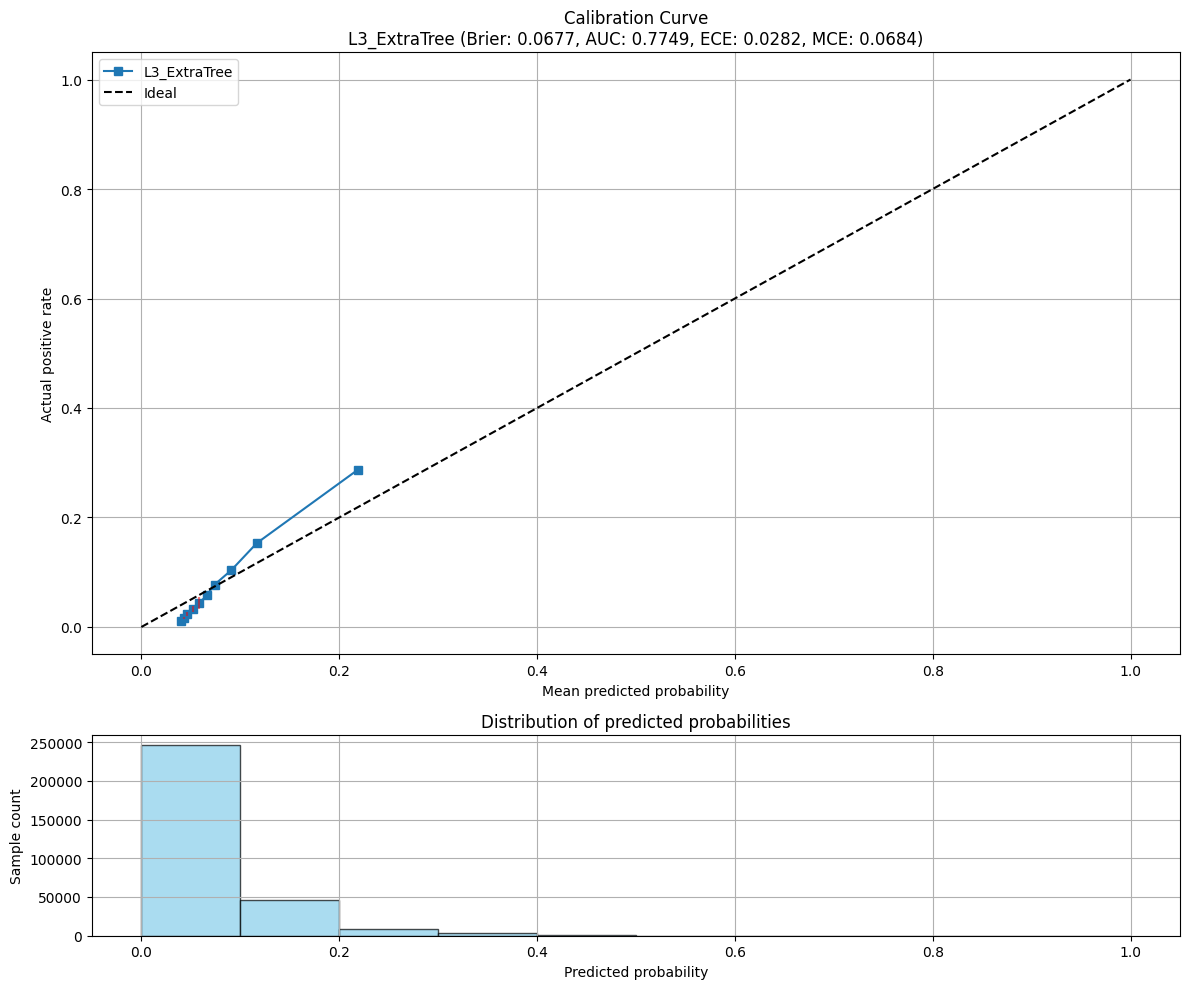


Overall Calibration Metrics:


,brier_score,roc_auc,ece,mce,calibration_curve
0,0.067731,0.774908,0.028237,0.068387,"([0.011016222737229754, 0.016669974201230404, ..."



Note: This approach loads data directly from CSV files and handles all file operations automatically.


In [14]:
# File-based comprehensive calibration analysis
print("Running comprehensive calibration analysis (file-based approach)...")

# Create output directory for demonstration purposes only
output_dir = "notebook_results/calibration_demo"
os.makedirs(output_dir, exist_ok=True)

# 1. Overall calibration analysis - loads data directly from CSV files
print("\n1. Overall Model Calibration (from CSV files):")
overall_metrics = run_calibration_analysis(
    oof_path='../models/l3_stacking/l3_extratree_oof_predictions.csv',
    target_path='../data/raw/application_train.csv',
    model_name="L3_ExtraTree",
    group_col=None,  # No grouping for overall analysis
    save_dir=None,  # Don't save files
    show_plot=True
)

# Display overall metrics as DataFrame
print("\nOverall Calibration Metrics:")
display(overall_metrics)
print("\nNote: This approach loads data directly from CSV files and handles all file operations automatically.")

## 3. Group-wise Calibration Analysis

Group-wise calibration analysis examines whether the model is equally well-calibrated across different segments. **This analysis REQUIRES raw data** because we need categorical columns for meaningful business segmentation.

### Why Raw Data is Essential for Group Analysis:

**Categorical Information**: Only raw data retains original categorical values like:
- `NAME_EDUCATION_TYPE`: Secondary, Higher education, Incomplete higher, etc.
- `CODE_GENDER`: M, F
- `NAME_INCOME_TYPE`: Working, Commercial associate, Pensioner, etc.

**Business Interpretability**: Groups based on original categories are meaningful for:
- Regulatory reporting and compliance
- Business decision-making
- Risk management strategies

**Processed Data Limitation**: In processed data, categorical variables are encoded (one-hot, label encoding) losing their business meaning.

### Business Applications:
- **Fair lending compliance**: Ensuring consistent calibration across demographic groups
- **Risk management**: Identifying segments with poor calibration
- **Model monitoring**: Detecting calibration drift in specific populations

### Analysis Process:
1. **Group Selection**: Choose a categorical variable from raw data for segmentation
2. **Individual Analysis**: Run calibration analysis for each group
3. **Comparison**: Compare metrics across groups to identify issues

Running automated group-wise calibration analysis for: NAME_EDUCATION_TYPE

Analyzing calibration by 'NAME_EDUCATION_TYPE':
Group distribution:
   Secondary / secondary special: 218,391 samples (71.0%)
   Higher education: 74,863 samples (24.3%)
   Incomplete higher: 10,277 samples (3.3%)
   Lower secondary: 3,816 samples (1.2%)
   Academic degree: 164 samples (0.1%)

Selected 4 groups with >= 1000 samples:
   Secondary / secondary special (218,391 samples)
   Higher education (74,863 samples)
   Incomplete higher (10,277 samples)
   Lower secondary (3,816 samples)

Running calibration analysis for 4 groups...

Calibration analysis for L3_ExtraTree

Calibration analysis for L3_ExtraTree


Processing groups (NAME_EDUCATION_TYPE):   0%|          | 0/4 [00:00<?, ?it/s]


[1/4] Processing group NAME_EDUCATION_TYPE = Secondary / secondary special (218391 samples)


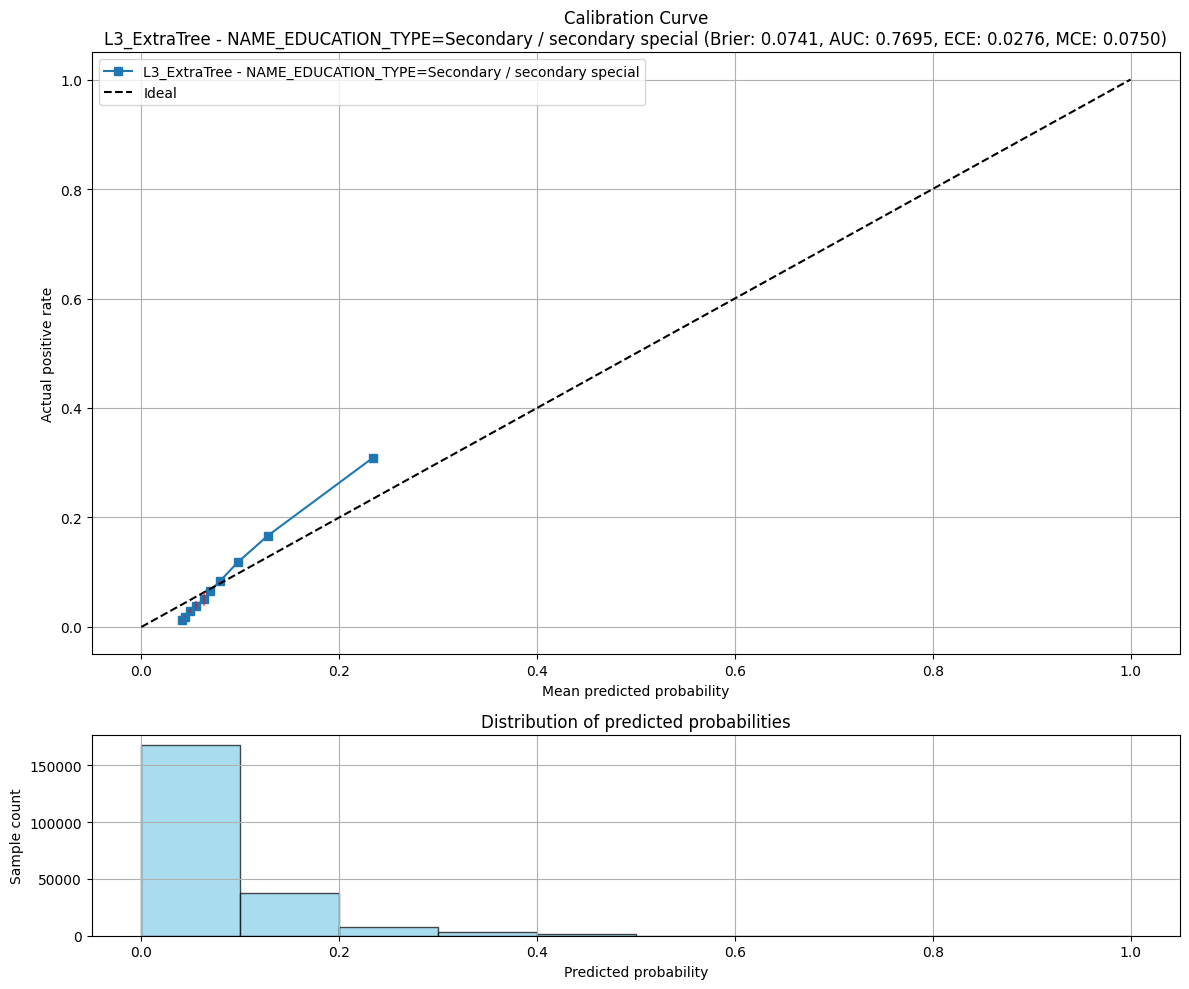

Processing groups (NAME_EDUCATION_TYPE):  25%|██▌       | 1/4 [00:00<00:01,  2.19it/s]

    Done group NAME_EDUCATION_TYPE = Secondary / secondary special in 0.3 seconds.

[2/4] Processing group NAME_EDUCATION_TYPE = Higher education (74863 samples)


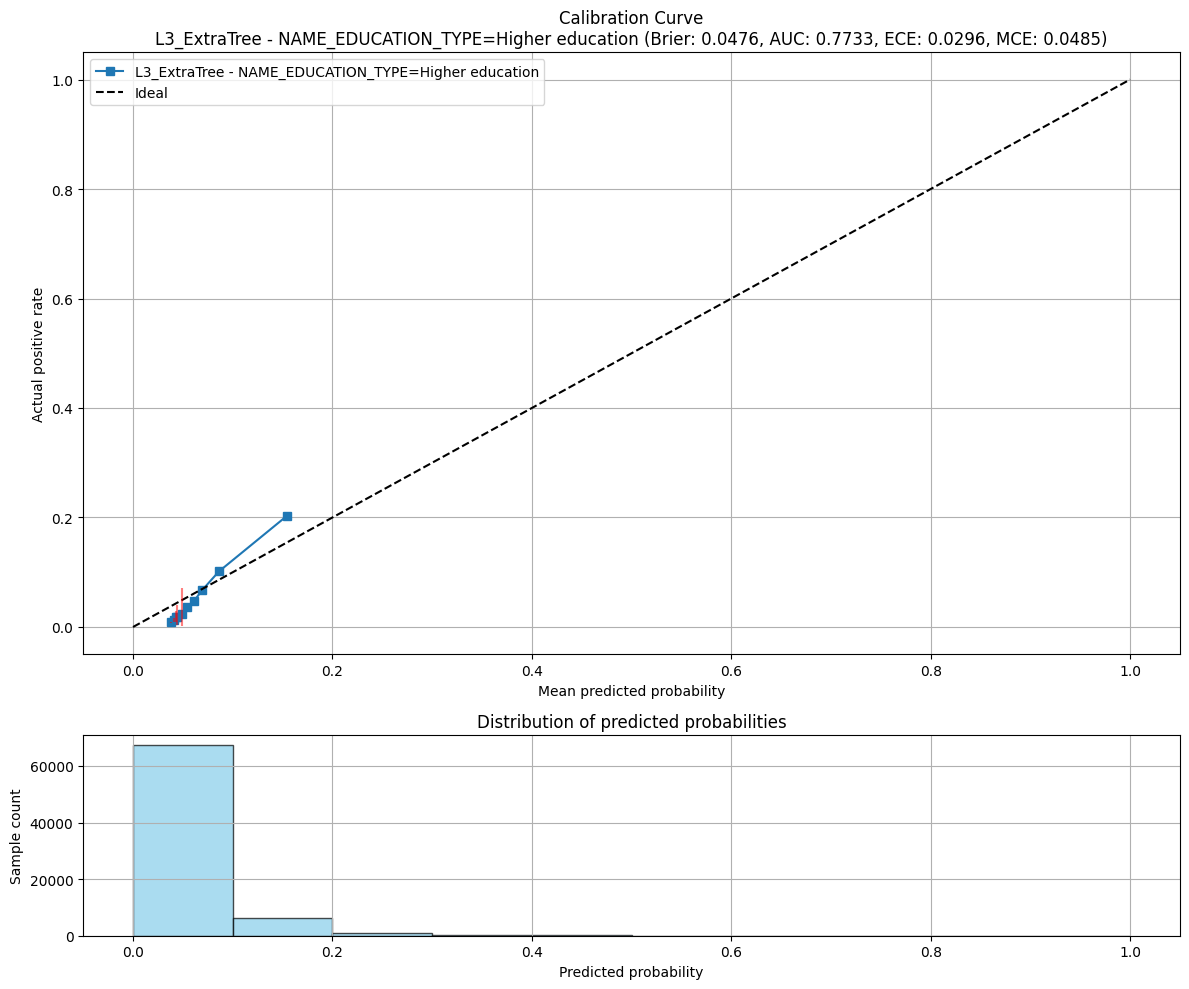

Processing groups (NAME_EDUCATION_TYPE):  50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

    Done group NAME_EDUCATION_TYPE = Higher education in 0.2 seconds.

[3/4] Processing group NAME_EDUCATION_TYPE = Incomplete higher (10277 samples)


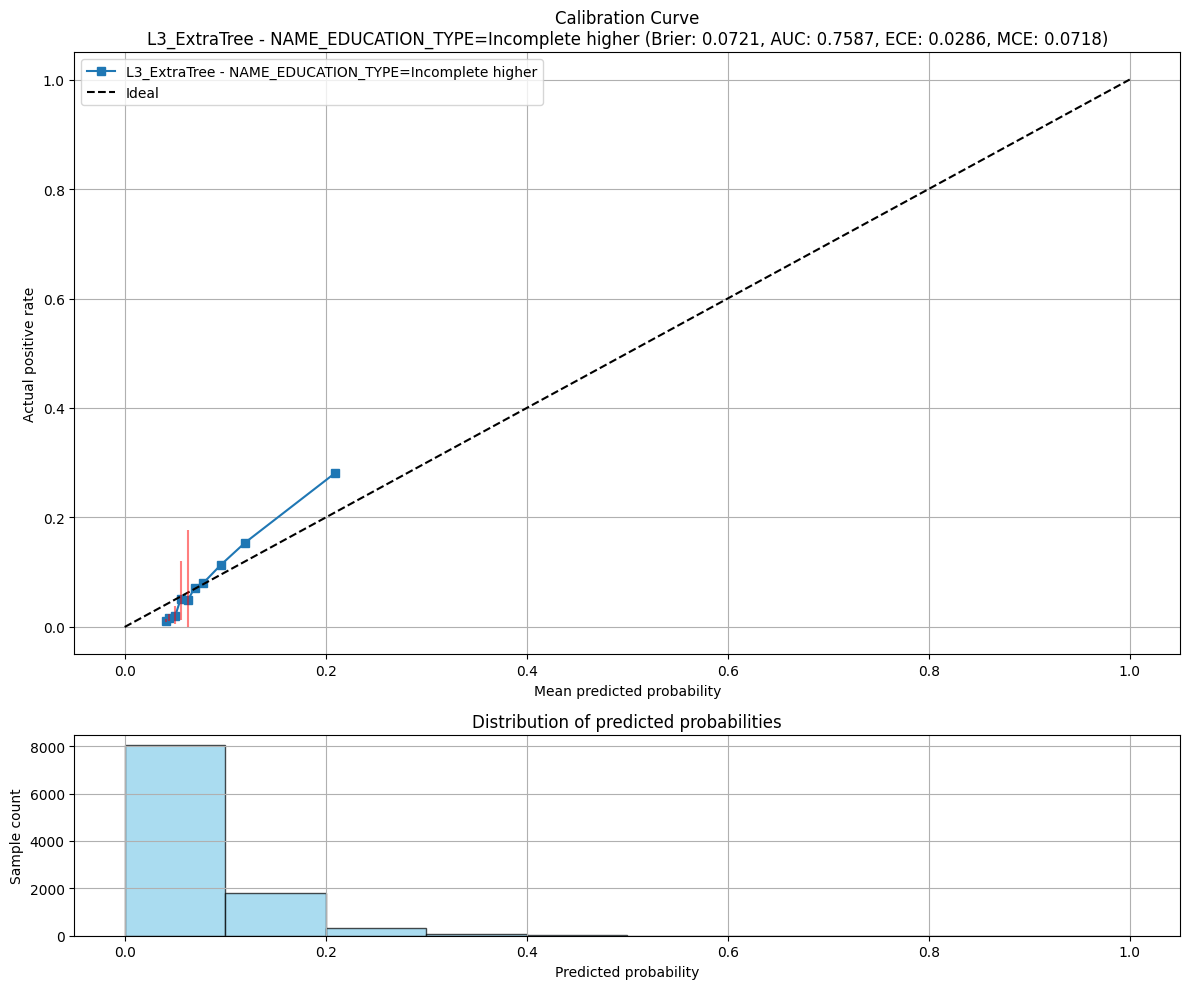

Processing groups (NAME_EDUCATION_TYPE):  75%|███████▌  | 3/4 [00:00<00:00,  3.24it/s]

    Done group NAME_EDUCATION_TYPE = Incomplete higher in 0.2 seconds.

[4/4] Processing group NAME_EDUCATION_TYPE = Lower secondary (3816 samples)


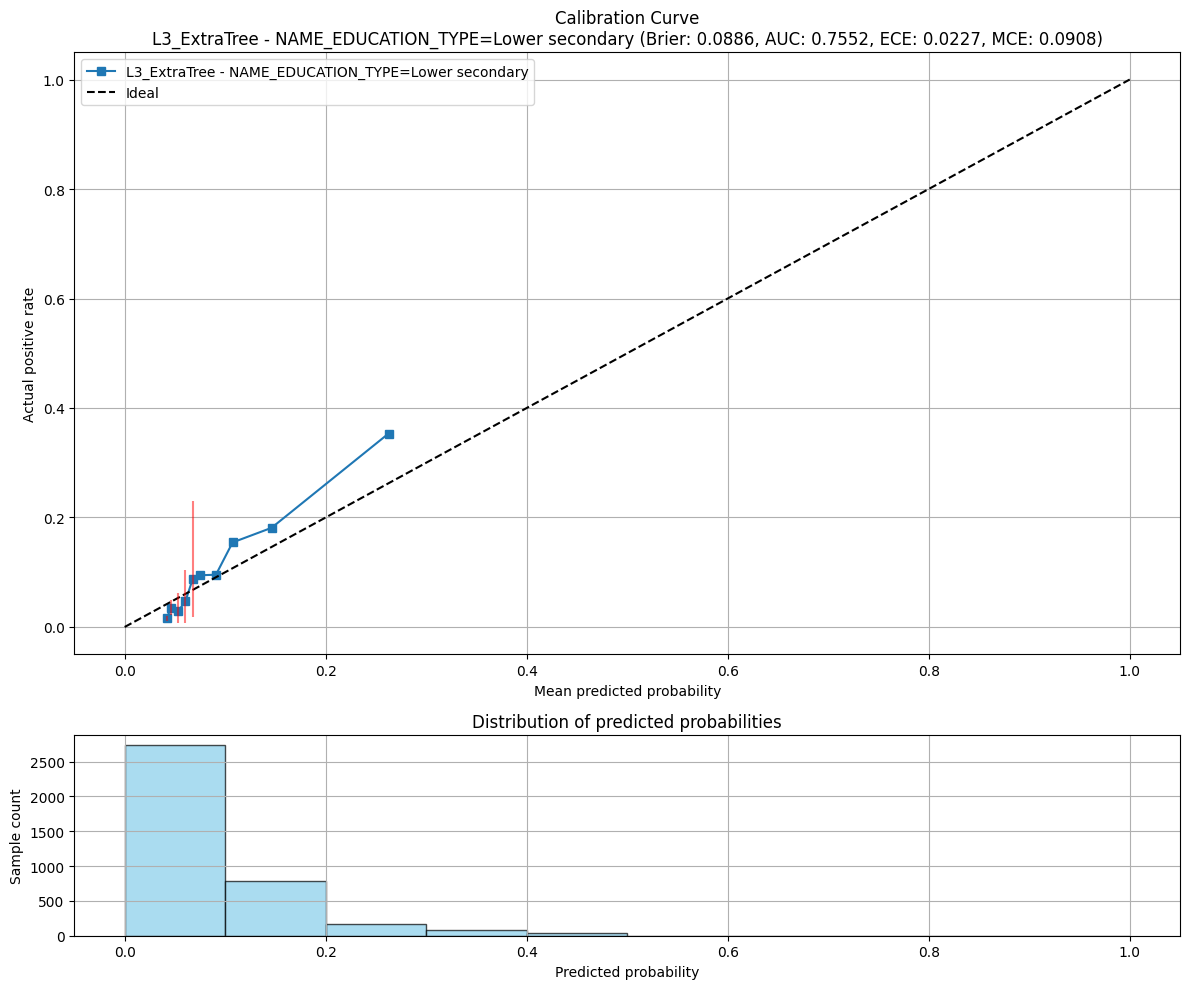

Processing groups (NAME_EDUCATION_TYPE): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

    Done group NAME_EDUCATION_TYPE = Lower secondary in 0.3 seconds.

GROUP-WISE CALIBRATION RESULTS BY NAME_EDUCATION_TYPE


,brier_score,roc_auc,ece,mce,calibration_curve
Group,,,,,
Secondary / secondary special,0.074111,0.769498,0.027632,0.074954,"([0.011985052861830114, 0.018761467889908255, ..."
Higher education,0.047563,0.773275,0.029623,0.048506,"([0.008588794926004228, 0.012682137075013492, ..."
Incomplete higher,0.072069,0.758695,0.028649,0.071786,"([0.011661807580174927, 0.016553067185978577, ..."
Lower secondary,0.088574,0.755158,0.022727,0.090810,"([0.015544041450777202, 0.03439153439153439, 0..."



AUTOMATIC INSIGHTS:
   Groups analyzed: 4
   ECE Range: 0.0227 - 0.0296
   ECE Standard Deviation: 0.0031
   Best calibrated group: Lower secondary (ECE: 0.0227)
   Worst calibrated group: Higher education (ECE: 0.0296)
   Overall Quality: EXCELLENT - All groups show good calibration

AUTOMATION COMPLETE
To analyze a different category, change 'group_column' variable and re-run this cell


In [16]:
# =============================================================================
# AUTOMATED GROUP-WISE CALIBRATION ANALYSIS
# Simply change the group_column variable below to analyze different categories
# =============================================================================

# CONFIGURATION: Change this to analyze different categorical columns
group_column = 'NAME_EDUCATION_TYPE'  # Options: 'CODE_GENDER', 'NAME_INCOME_TYPE', etc.

print(f"Running automated group-wise calibration analysis for: {group_column}")
print("=" * 60)

# Check if the column exists in the data
if group_column not in target_data.columns:
    print(f"ERROR: Column '{group_column}' not found in data!")
    print(f"Available categorical columns: {target_data.select_dtypes(include=['object']).columns.tolist()}")
else:
    # Automatically analyze the specified grouping variable
    available_groups = target_data[group_column].value_counts()
    print(f"\nAnalyzing calibration by '{group_column}':")
    print("Group distribution:")
    for group, count in available_groups.head(10).items():
        print(f"   {group}: {count:,} samples ({count/len(target_data)*100:.1f}%)")
    
    if len(available_groups) > 10:
        print(f"   ... and {len(available_groups)-10} more groups")
    
    # Automatically select groups with sufficient samples
    min_samples = 1000  # Minimum samples per group for reliable analysis
    selected_groups = available_groups[available_groups >= min_samples].index.tolist()
    
    if len(selected_groups) == 0:
        print(f"\nWARNING: No groups have >= {min_samples} samples for reliable analysis")
        print("Lowering threshold to 500 samples...")
        min_samples = 500
        selected_groups = available_groups[available_groups >= min_samples].index.tolist()
    
    print(f"\nSelected {len(selected_groups)} groups with >= {min_samples} samples:")
    for group in selected_groups[:5]:  # Show first 5
        print(f"   {group} ({available_groups[group]:,} samples)")
    if len(selected_groups) > 5:
        print(f"   ... and {len(selected_groups)-5} more groups")
    
    # Automatically run group-wise analysis
    if len(selected_groups) > 0:
        print(f"\nRunning calibration analysis for {min(len(selected_groups), 5)} groups...")
        
        group_metrics = run_calibration_analysis(
            oof_path='../models/l3_stacking/l3_extratree_oof_predictions.csv',
            target_path='../data/raw/application_train.csv',
            model_name="L3_ExtraTree",
            group_col=group_column,
            group_values=selected_groups[:5],  # Analyze top 5 groups to avoid too many plots
            save_dir=None,  # Don't save files
            show_plot=True
        )
        
        # Automatically process and display results
        group_metrics_df = pd.DataFrame.from_dict(group_metrics, orient='index')
        group_metrics_df.index.name = 'Group'
        
        print(f"\n" + "="*60)
        print(f"GROUP-WISE CALIBRATION RESULTS BY {group_column}")
        print(f"="*60)
        display(group_metrics_df)
        
        # Automatically generate insights
        print(f"\nAUTOMATIC INSIGHTS:")
        print(f"   Groups analyzed: {len(group_metrics_df)}")
        print(f"   ECE Range: {group_metrics_df['ece'].min():.4f} - {group_metrics_df['ece'].max():.4f}")
        print(f"   ECE Standard Deviation: {group_metrics_df['ece'].std():.4f}")
        
        best_group = group_metrics_df['ece'].idxmin()
        worst_group = group_metrics_df['ece'].idxmax()
        print(f"   Best calibrated group: {best_group} (ECE: {group_metrics_df.loc[best_group, 'ece']:.4f})")
        print(f"   Worst calibrated group: {worst_group} (ECE: {group_metrics_df.loc[worst_group, 'ece']:.4f})")
        
        # Automatic calibration quality assessment
        avg_ece = group_metrics_df['ece'].mean()
        if avg_ece < 0.05:
            quality = "EXCELLENT - All groups show good calibration"
        elif avg_ece < 0.10:
            quality = "GOOD - Most groups are well calibrated"  
        elif avg_ece < 0.15:
            quality = "MODERATE - Some groups need attention"
        else:
            quality = "POOR - Significant calibration issues across groups"
            
        print(f"   Overall Quality: {quality}")
        
        # Flag groups that need attention
        poor_groups = group_metrics_df[group_metrics_df['ece'] > 0.10].index.tolist()
        if poor_groups:
            print(f"   Groups needing attention (ECE > 0.10): {poor_groups}")
        
    else:
        print(f"\nNo groups found with sufficient samples (>= {min_samples}) for reliable analysis.")

print(f"\n" + "="*60)
print("AUTOMATION COMPLETE")
print("To analyze a different category, change 'group_column' variable and re-run this cell")
print(f"="*60)

## 4. Multi-Model Calibration Comparison

The `plot_multiple_calibration_curves()` function allows comparison of calibration curves from multiple models on the same plot. This is useful for:

### Model Selection:
- Compare calibration quality across different algorithms
- Identify which models require calibration adjustment
- Support ensemble model decisions

### Expected Input Format:
```python
results = {
    "Model1": (y_true, y_pred_proba1),
    "Model2": (y_true, y_pred_proba2),
    # ...
}
```


3. Multi-Model Calibration Comparison:
Creating synthetic model variations for comparison demo...

Comparing 3 model variants...


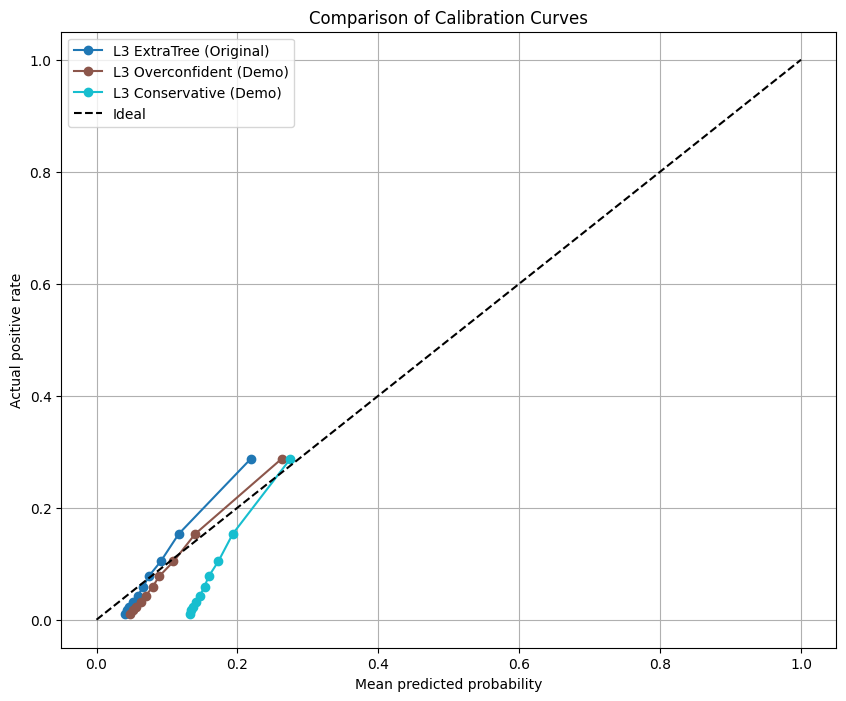


Calibration Metrics Comparison:


,Model,brier_score,roc_auc,ece,mce
0,L3 ExtraTree (Original),0.067731,0.774908,0.028237,0.068387
1,L3 Overconfident (Demo),0.067461,0.774908,0.036115,0.036975
2,L3 Conservative (Demo),0.075550,0.774908,0.117086,0.120978



Best calibrated model: L3 ExtraTree (Original) (ECE: 0.0282)


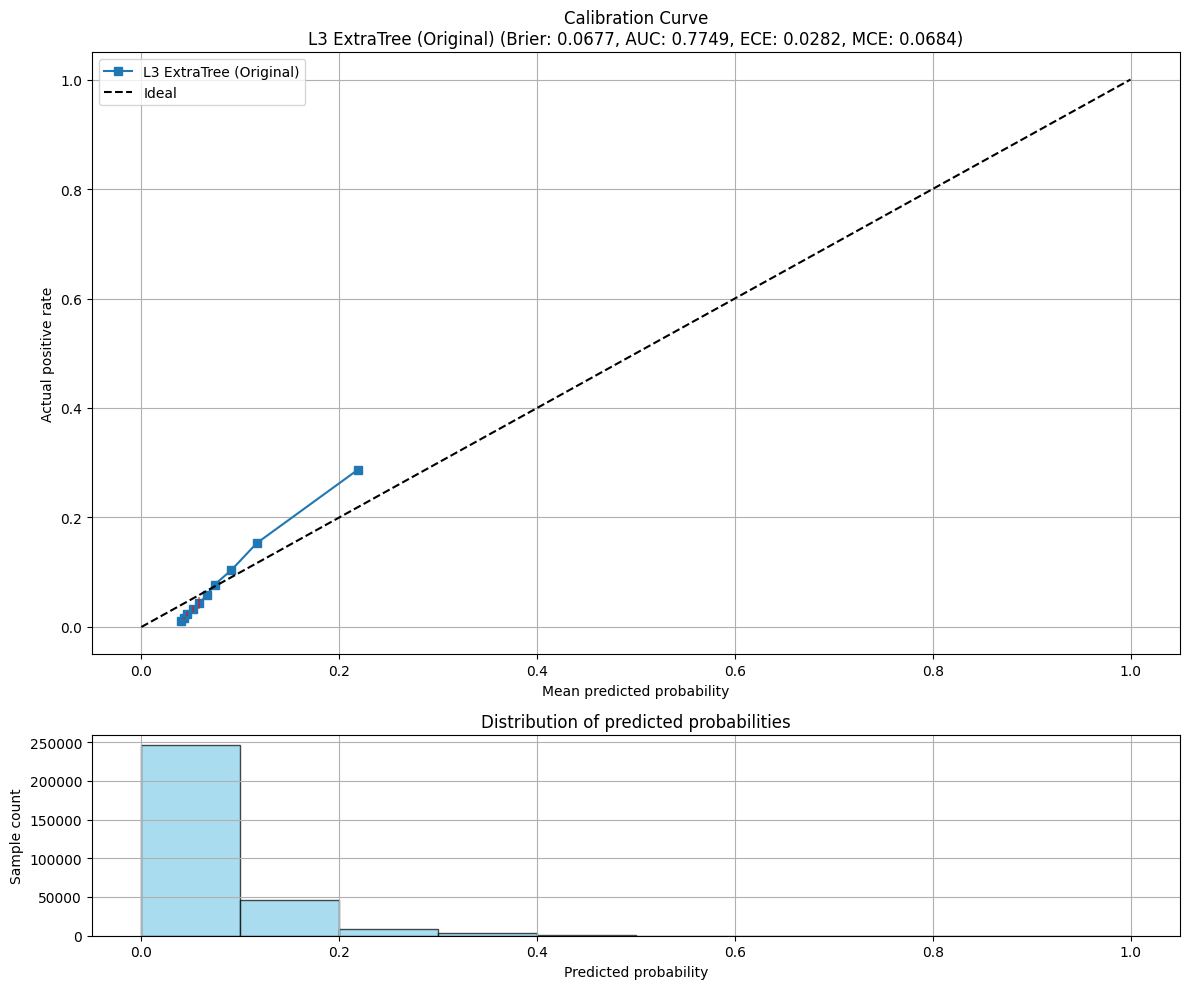

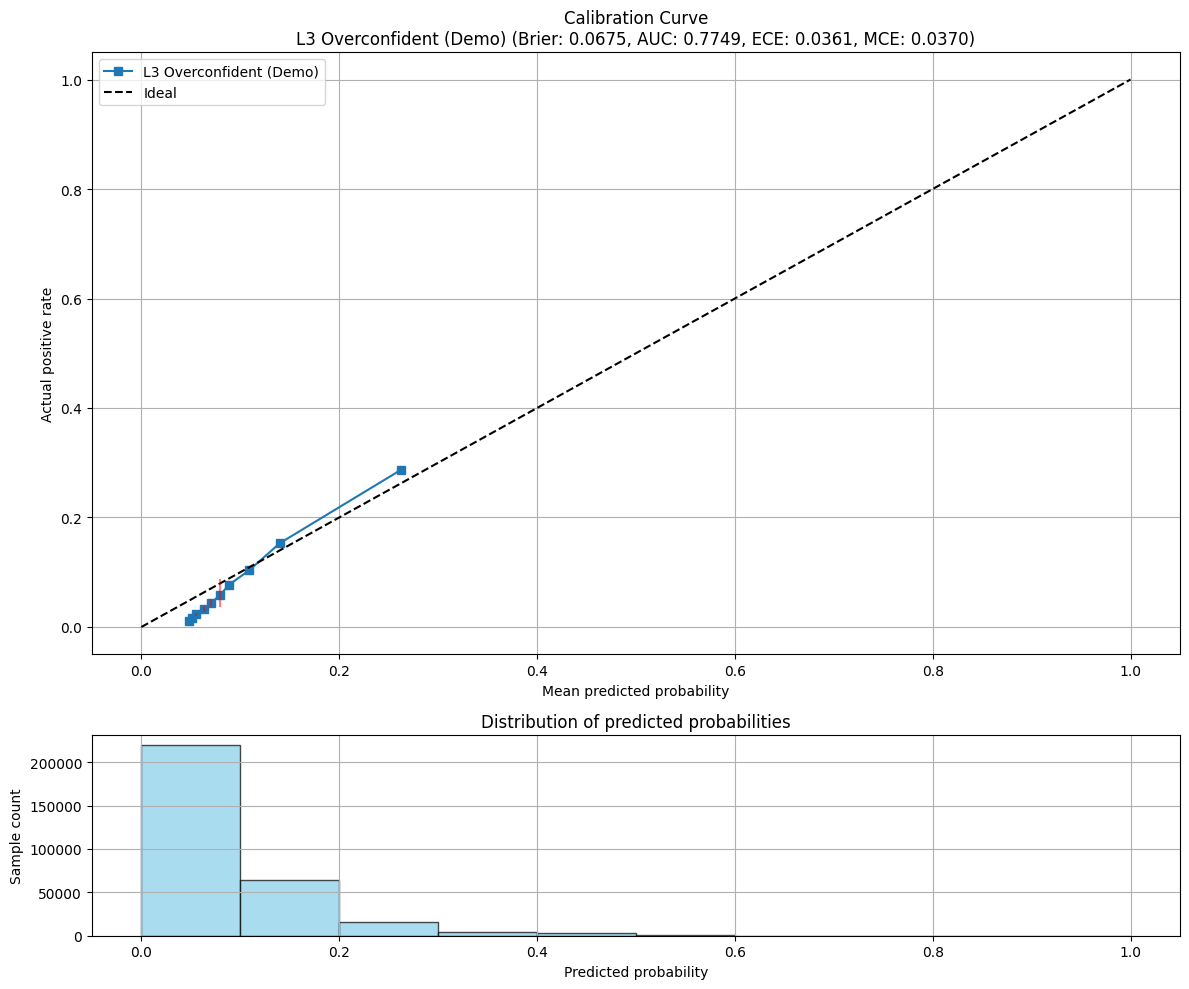

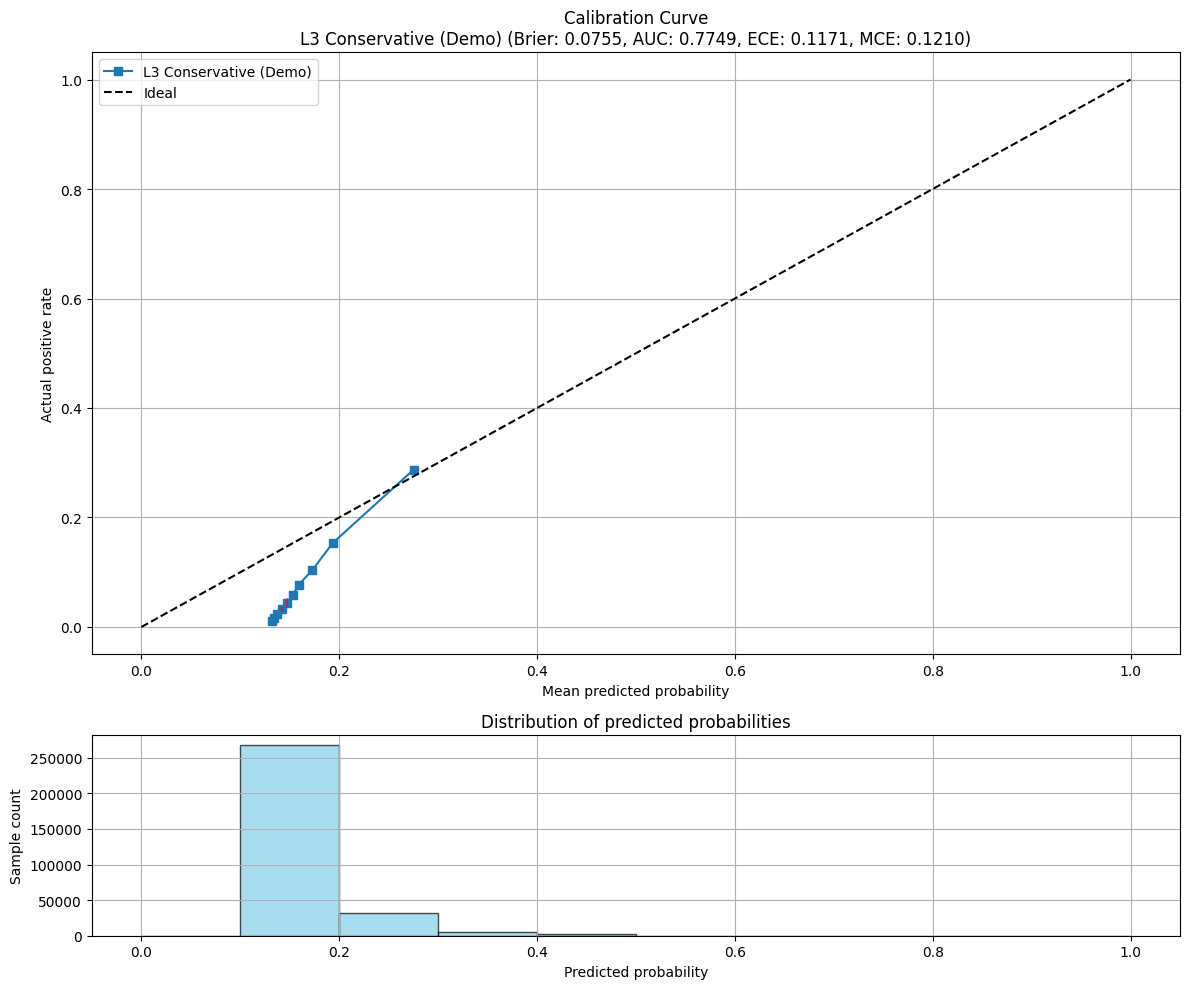

In [17]:
# Multi-model calibration comparison
print("\n3. Multi-Model Calibration Comparison:")

# For demonstration, we'll create multiple "models" by using different
# transformations of the same L3 predictions to show the comparison functionality
print("Creating synthetic model variations for comparison demo...")

# Original L3 model
l3_original = y_pred_proba

# Simulated "poorly calibrated" version (shifted probabilities)
l3_overconfident = np.clip(y_pred_proba * 1.2, 0, 1)  # More extreme predictions

# Simulated "conservative" version (compressed probabilities)
l3_conservative = y_pred_proba * 0.8 + 0.1  # Less extreme predictions

# Prepare results dictionary for comparison
model_results = {
    "L3 ExtraTree (Original)": (y_true, l3_original),
    "L3 Overconfident (Demo)": (y_true, l3_overconfident),
    "L3 Conservative (Demo)": (y_true, l3_conservative)
}

print(f"\nComparing {len(model_results)} model variants...")

# Create comparison plot
plot_multiple_calibration_curves(
    results=model_results,
    save_path=None,  # Don't save plot
    show_histogram=False,  # No histogram in comparison mode
    show_plot=True
)

# Calculate and compare metrics for all models
print("\nCalibration Metrics Comparison:")
comparison_metrics = []

for model_name, (y_true_model, y_pred_model) in model_results.items():
    metrics = plot_calibration_curve(
        y_true_model, y_pred_model,
        model_name=model_name,
        show_plot=False  # Don't show individual plots
    )
    metrics['Model'] = model_name
    comparison_metrics.append(metrics)

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_metrics)
comparison_df = comparison_df[['Model', 'brier_score', 'roc_auc', 'ece', 'mce']]

display(comparison_df)

# Identify best calibrated model
best_model_idx = comparison_df['ece'].idxmin()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_ece = comparison_df.loc[best_model_idx, 'ece']
print(f"\nBest calibrated model: {best_model} (ECE: {best_ece:.4f})")

## 5. Module Configuration and Production Usage

The calibration analysis module includes configuration options and production-ready features:

### Configuration Options:
- **GROUP_COL**: Default grouping variable (set to `"NAME_EDUCATION_TYPE"`)
- **File naming**: Automatic sanitization for safe file names
- **Progress tracking**: Built-in progress bars for group analysis

### Production Features:
- **Automatic directory creation**: Creates output directories as needed
- **Error handling**: Robust error handling for missing columns or files
- **Batch processing**: Efficient processing of multiple groups
- **Flexible output**: Options to show/hide plots and save results

### Command Line Usage:
The module can be run directly from command line:
```bash
python -m src.validation.calibration_analysis
```

This will automatically:
1. Run overall calibration analysis
2. Perform group-wise analysis by default GROUP_COL
3. Generate comparison plots
4. Save all results to `validation_results/calibration_results/`

In [18]:
# Summary of calibration analysis results
print("\nSUMMARY OF CALIBRATION ANALYSIS:")
print("=" * 50)

# Key insights summary
print(f"\nKEY INSIGHTS:")
print(f"   Model: L3 ExtraTree")
print(f"   Overall ECE: {overall_metrics.iloc[0]['ece']:.4f}")
print(f"   Overall Brier Score: {overall_metrics.iloc[0]['brier_score']:.4f}")
print(f"   Overall ROC AUC: {overall_metrics.iloc[0]['roc_auc']:.4f}")

if 'group_metrics_df' in locals():
    print(f"\n   Group Analysis ({group_column}):")
    print(f"   - Groups analyzed: {len(group_metrics_df)}")
    print(f"   - ECE range: {group_metrics_df['ece'].min():.4f} - {group_metrics_df['ece'].max():.4f}")
    print(f"   - Best group: {group_metrics_df['ece'].idxmin()}")
    print(f"   - Worst group: {group_metrics_df['ece'].idxmax()}")

print(f"\nRECOMMENDATIONS:")
ece_overall = overall_metrics.iloc[0]['ece']
if ece_overall < 0.05:
    print(f"   - Model shows excellent calibration")
    print(f"   - No immediate calibration adjustment needed")
elif ece_overall < 0.10:
    print(f"   - Model shows good calibration")
    print(f"   - Monitor calibration in production")
else:
    print(f"   - Model calibration needs improvement")
    print(f"   - Consider post-hoc calibration methods (Platt scaling, Isotonic regression)")
    
print(f"\nCalibration analysis completed successfully!")


SUMMARY OF CALIBRATION ANALYSIS:

KEY INSIGHTS:
   Model: L3 ExtraTree
   Overall ECE: 0.0282
   Overall Brier Score: 0.0677
   Overall ROC AUC: 0.7749

   Group Analysis (NAME_EDUCATION_TYPE):
   - Groups analyzed: 4
   - ECE range: 0.0227 - 0.0296
   - Best group: Lower secondary
   - Worst group: Higher education

RECOMMENDATIONS:
   - Model shows excellent calibration
   - No immediate calibration adjustment needed

Calibration analysis completed successfully!


## 6. Summary and Implementation Guide

### Core Functions Overview:

**1. `plot_calibration_curve(y_true, y_pred_proba, n_bins=10, model_name, strategy='quantile', show_histogram=True, confidence_intervals=True, save_path=None, show_plot=True)`**
- Creates detailed calibration plots with confidence intervals and histograms
- Returns calibration metrics: Brier score, ROC AUC, ECE, MCE
- Uses quantile-based binning for stable estimates

**2. `run_calibration_analysis(oof_path, target_path, model_name, group_col=None, group_values=None, save_dir=None, show_plot=True)`**
- Comprehensive analysis workflow from CSV files
- Supports both overall and group-wise analysis
- Automatic file handling and result saving
- Progress tracking for group processing

**3. `plot_multiple_calibration_curves(results, save_path=None, show_histogram=False, show_plot=True)`**
- Compares multiple models on single plot
- Input format: `{"Model_Name": (y_true, y_pred_proba)}`
- Useful for model selection and comparison

### Calibration Metrics Interpretation:

| Metric | Description | Good Values | Interpretation |
|--------|-------------|-------------|----------------|
| **Brier Score** | Mean squared difference between predicted probabilities and actual outcomes | < 0.1 | Lower is better, measures accuracy of probabilistic predictions |
| **ROC AUC** | Area under ROC curve | > 0.7 | Discrimination ability, higher is better |
| **ECE** | Expected Calibration Error | < 0.05 | Average calibration error across bins, lower is better |
| **MCE** | Maximum Calibration Error | < 0.1 | Worst-case calibration error, lower is better |

### Production Implementation:

**File Structure Requirements:**
- OOF predictions: Must contain column `'oof_preds'`
- Target file: Must contain column `'TARGET'`
- Group analysis: Any categorical column in target file

**Automated Execution:**
```bash
python -m src.validation.calibration_analysis
```

**Output Structure:**
- `validation_results/calibration_results/`
- Overall calibration plots and metrics
- Group-wise analysis results
- Model comparison visualizations

### Business Applications:

- **Model Validation**: Ensure predicted probabilities are reliable
- **Regulatory Compliance**: Demonstrate model fairness across groups
- **Risk Management**: Identify segments with poor calibration
- **Model Monitoring**: Track calibration drift over time
- **Decision Making**: Support probability-based business decisions

The calibration analysis module provides comprehensive tools for validating and monitoring the reliability of probabilistic predictions in credit risk models.